In [1]:
%pylab inline
import numpy as np
from scipy.spatial.distance import cdist
import sys
sys.path.append("../")
import sgd
reload(sgd)
import theano
import theano.tensor as T
import topogen
import sklearn.datasets
import util
import cPickle as pickle
import exputil
import time
import pandas as pd
import seaborn as sns
import sklearn.metrics

Populating the interactive namespace from numpy and matplotlib


(1600, 1600)


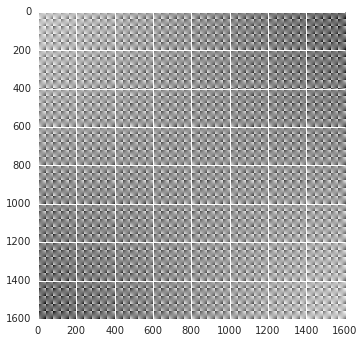

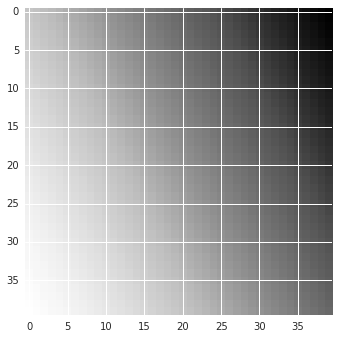

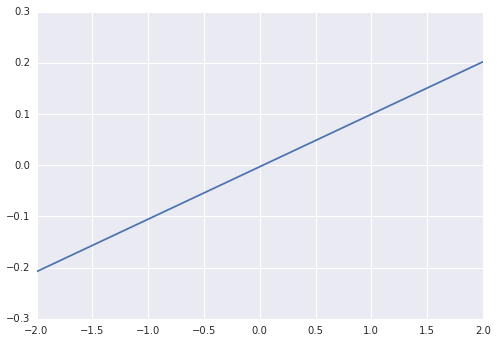

In [2]:
import kernels
reload(kernels)
reload(exputil)

kern_func = kernels.inner_product() # , 1.0) # , 3.0)

kern_f = exputil.make_kern_f(kern_func)
N = 40
x = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, x)
points = np.array([xv.flatten(), yv.flatten()]).T
#points = np.meshgrid()
r  = kern_f(points, [2, -1])
print r.shape
pylab.imshow(r, interpolation='nearest')
pylab.figure()
pylab.imshow(r[N**2/2 + N/2].reshape((N, N)), interpolation='nearest')
pylab.figure()
pylab.plot(x, r[N**2/2 + N/2].reshape((N, N))[N/2])

<matplotlib.colorbar.Colorbar instance at 0x7f553d8cae18>

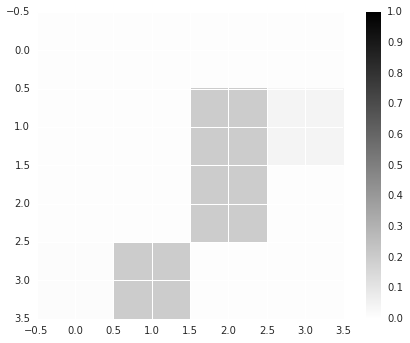

In [48]:
import synthetic
reload(synthetic)
np.random.seed(9)
G = synthetic.stochastic_block_model(4, 100, symmetric=False, conn_alpha_beta=(0.1, 1.0), 
                                        pmax=0.2, pmin=0.01)# , manual_weights = {(0, 1): 0.9, (1, 2) : 0.9, 
                                             #                 (1, 0): 0.9, (2, 1): 0.9})
import networkx as nx
obs = synthetic.get_adj_mat(G)

pylab.imshow(G.graph['latent_mat'], interpolation='nearest', cmap=pylab.cm.gray_r, vmin=0, vmax=1)
pylab.colorbar()

In [49]:
nodemeta = []
for ni, n in enumerate(G.nodes()):
    attr = {'node_pos' :  ni, 
            'node_name' : n}
    attr.update(G.node[n])
    nodemeta.append(attr)
df = pd.DataFrame(nodemeta)
df.index = df['node_pos']
df.head()

block  node_name  node_pos
node_pos                            
0             1          0         0
1             3          1         1
2             1          2         2
3             0          3         3
4             0          4         4

In [46]:
assignments = [G.node[g]['block'] for g in G.nodes()]
ai = np.argsort(assignments).flatten()

(100, 100)


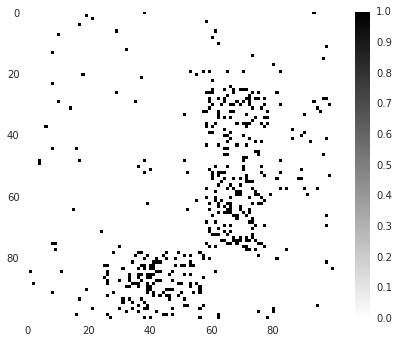

In [50]:
reload(sgd)
import losses
reload(losses)
N = len(obs)
D = 3

lossobj = losses.Logistic(0.5)

print obs.shape

obs_frac = 0.90
obsvalid = np.random.rand(*obs.shape) < obs_frac

obs_sorted = obs[ai]
obs_sorted = obs_sorted[:, ai]

pylab.imshow(obs_sorted, interpolation='nearest', cmap=pylab.cm.gray_r)
pylab.colorbar()
pylab.grid()

In [50]:
### 
reload(sgd)
reload(exputil)
import time

XINIT_N = 4
#xinit = [np.random.normal(0, std, (N, D)) for std in np.logspace(-1.5, 1, XINIT_N)]
xinit = [np.random.normal(0, 0.1, (N, D)) for _ in range(XINIT_N)]
#xinit.append(xtrue.copy())
xinit = np.array(xinit)
print xinit.shape
theta_init = np.ones(D) 

ALPHAS = np.logspace(-1, -4, 10)
BATCH_RATIOS = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.4])
t1 = time.time()
res = exputil.sgd_param_test_par(kern_func, lossobj.cost(), 
                            xinit, theta_init,  obs,  np.ones_like(obs), 
                            alphas = ALPHAS, batch_ratios= BATCH_RATIOS, 
                            use_adagrad = True, 
                            theta_inference=True, iters=100)
t2 = time.time()
print "took", t2-t1, "secs"

(4, 400, 3)
took 58.2561240196 secs


In [51]:
reload(exputil)
best_param = exputil.get_best_run_params(res)
#print best_param

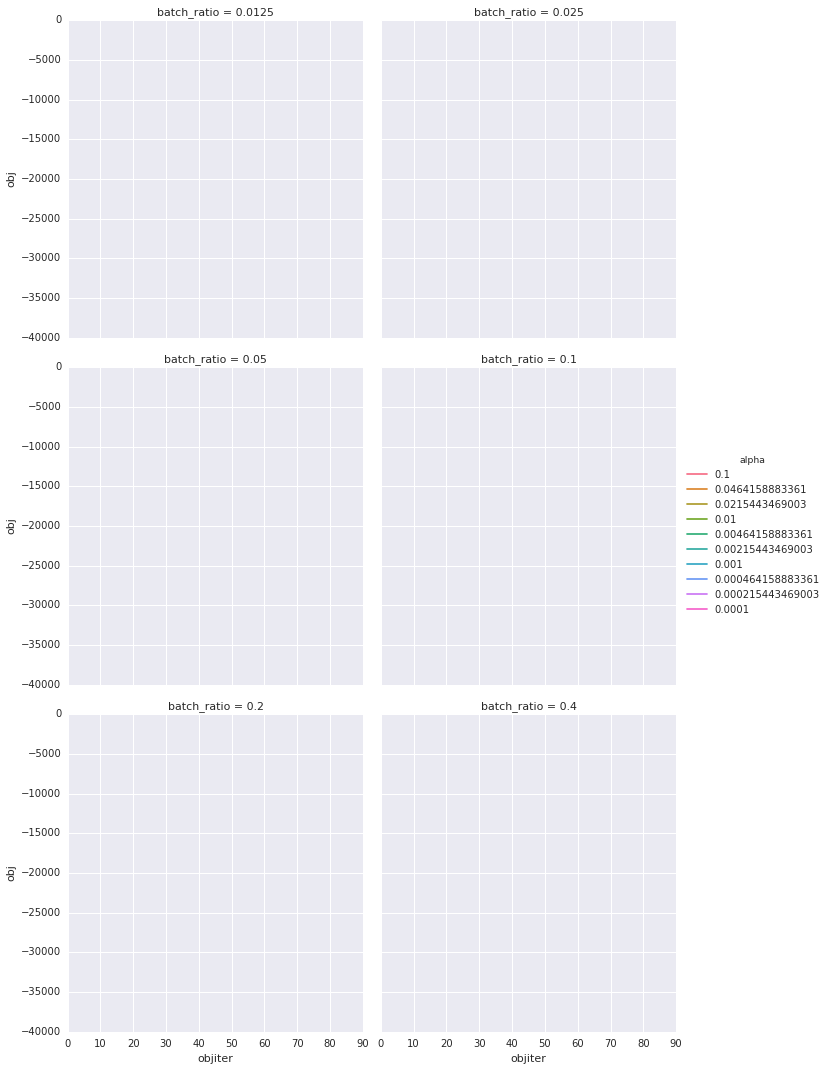

In [52]:
allres = []
for r in res:
    for oi, o in enumerate(r['obj_log']):
        rc = r.copy()
        del rc['obj_log']
        rc['obj'] = o
        rc['objiter'] = oi*10
        allres.append(rc)
df = pd.DataFrame(allres)
def mdf(arg1, arg2, data, color, label):
    for gi, g in data.groupby('xinit_i'):
        pylab.plot(g[arg1], g[arg2], c=color, label=label
                  )
grid = sns.FacetGrid(df, col="batch_ratio", hue="alpha", col_wrap=2, size=5)


# Draw a line plot to show the trajectory of each random walk
#grid.map(plt.plot, "objiter", "obj") # , marker="o", ms=4)
grid.map_dataframe(mdf, 'objiter', 'obj')
# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)
grid.set(ylim=-40000)
sns.despine()
grid.add_legend()

In [53]:
### 
ITERS = 10000

alpha = best_param['alpha']
obs_valid = np.ones_like(obs) > 0

xinit = np.random.normal(0, 0.5, (N, D))
theta_init = np.ones(D) 
batch_size = int(best_param['batch_ratio'] * N)

t1 = time.time()
res = sgd.run_sgd_full(kern_func, lossobj.cost(), 
                   xinit, theta_init, obs, obs_valid, batch_size=batch_size, 
                   alpha=alpha, iters=ITERS, use_adagrad=True, partition_batch=True, 
                   theta_inference=True, theta_alpha=1e-5,
                   verbose=True, verbose_iter=1000)
print 'total time was', time.time() - t1

0 obj= -228170.779853 ||grad||= 5945.30653176 ||x||= 16.1809422722 0.00
1000 obj= -71451.5437869 ||grad||= 644.104723423 ||x||= 16.0056829136 0.32
2000 obj= -71388.7051854 ||grad||= 758.126904149 ||x||= 15.7667914994 0.63
3000 obj= -71360.046874 ||grad||= 763.552887945 ||x||= 15.6352361375 0.95
4000 obj= -71315.9525259 ||grad||= 717.032537302 ||x||= 15.3947310754 1.26
5000 obj= -71269.7763088 ||grad||= 740.658455858 ||x||= 15.1997577856 1.58
6000 obj= -71236.9399153 ||grad||= 744.539844492 ||x||= 14.9691254909 1.90
7000 obj= -71207.9948626 ||grad||= 706.633270484 ||x||= 14.802561339 2.21
8000 obj= -71188.1510612 ||grad||= 742.790082136 ||x||= 14.5874375118 2.53
9000 obj= -71174.0461245 ||grad||= 898.405041326 ||x||= 14.4128216931 2.84
total time was 191.080837011


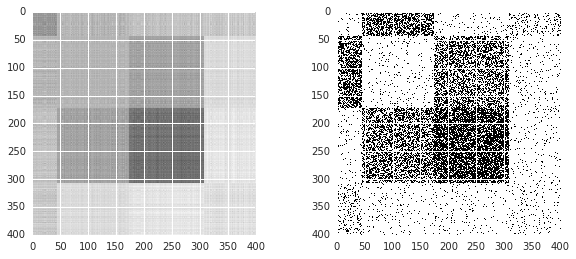

In [85]:
x_est = res['x_est']
theta_est = res['theta_est']
est_params = kern_f(x_est, theta_est)
ep =est_params[ai]
ep = ep[:, ai]
fig = pylab.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)

ax.imshow(ep, interpolation='nearest', vmin=0, vmax=1)
ax = fig.add_subplot(1, 2, 2)

ax.imshow(obs_sorted, interpolation='nearest',  vmin=0, vmax=1)


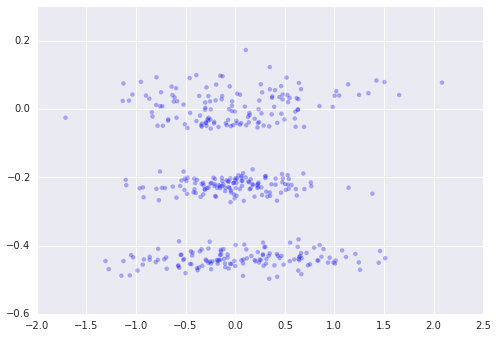

In [56]:

pylab.scatter(x_est[:, 0], x_est[:,1], edgecolor='none', alpha=0.3)
#pylab.scatter(xtrue[:, 0], xtrue[:, 1], c='r', edgecolor='none')


In [95]:
### 
reload(sgd)
ITERS = 4

obs_valid = np.ones_like(obs) > 0

xinit = np.random.normal(0, 0.1, (N, D))
theta_init = np.ones(D) 
batch_size = int(best_param['batch_ratio'] * N)

t1 = time.time()
res = sgd.run_bfgs(kern_func, lossobj.cost(), 
                   xinit, theta_init, obs, obs_valid,
                   iters=ITERS, 
                   theta_inference=True)
print "total time was", time.time() - t1

71052.2894741 True
71052.2234544 True
71052.8436708 True
71053.1502094 False
total time was 158.129214048


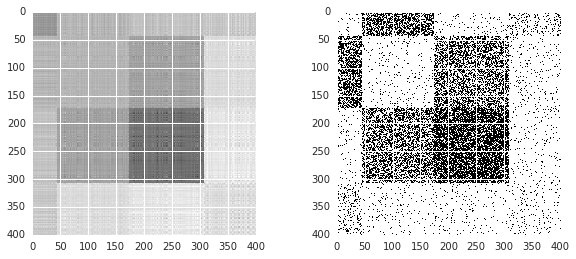

In [96]:
x_est = res['x_est']
theta_est = res['theta_est']
est_params = kern_f(x_est, theta_est)
ep =est_params[ai]
ep = ep[:, ai]
fig = pylab.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)

ax.imshow(ep, interpolation='nearest', vmin=0, vmax=1)
ax = fig.add_subplot(1, 2, 2)

ax.imshow(obs_sorted, interpolation='nearest',  vmin=0, vmax=1)


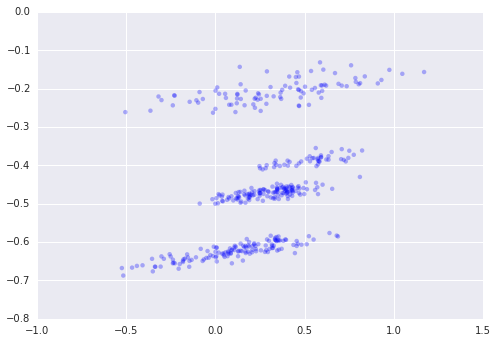

In [98]:
x_est = res['x_est']
pylab.scatter(x_est[:, 0], x_est[:,2], edgecolor='none', alpha=0.3)
#pylab.scatter(xtrue[:, 0], xtrue[:, 1], c='r', edgecolor='none')
